# Objetivo:
   **Trazer Previsões de Vendas**
   
   **Análise e Compreensão de Acontecimentos**


# Importação dos Dados e Bibliotecas a serem usadas.  

In [48]:
import warnings
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings('ignore')

In [49]:
dias_eventos = pd.read_csv('holidays_events.csv')
petroleo = pd.read_csv('oil.csv')
teste = pd.read_csv('test.csv')
treino = pd.read_csv('train.csv',index_col='date',parse_dates=True)
transacoes = pd.read_csv('transactions.csv')
lojas = pd.read_csv('stores.csv')

In [50]:
dias_eventos.head(6)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False


In [51]:
petroleo.head(6)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21


In [52]:
lojas.head(6)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13


In [53]:
transacoes.head(6)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903


In [54]:
treino.head(6)

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0
2013-01-01,5,1,BREAD/BAKERY,0.0,0


In [55]:
teste.head(6)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
5,3000893,2017-08-16,1,BREAD/BAKERY,12


# Explicação dos Dados:
   **Nosso desenvolvimento do projeto será realizado com dados de lojas localizadas no Equador.**
   
   Sabemos que o Equador é um páis dependente do Petróleo.
   
-   variável:
   'petroleo' --> Possui dados do preço diario do petroleo.
   
   
-   variável:
   'loja' --> Possui numero das lojas, a cidade e o estado que esta localizada, tipo, e agrupamento de lojas semelhantes.
   
   
-   variável:
   'transacoes' --> Possui numero da loja, a data, e a quantidade de transações.
   
   
-   variável:
   'dias_eventos' --> Possui a data do feriado, o tipo (se é feriado ou foi transferido para outro dia,ou se é feriado                                                              adicional,ou se é uma ponte dias extras,ou eventos,ou se não é destinado ao trabalho),
   a cidade, a descrição do feriado, se é regional ou local, e a data.
    
    
-   variáveis:
   'treino' e 'teste' --> Possui o segmento do produto vendido, a data, o numero da loja que foi realizada a compra, o total de vendas de um segmento de produtos em uma determinada loja em uma determinada data, e as ofertas que estavam sendo promovidas pelo segmento do produto.

# Informações dos Dados.

In [56]:
dias_eventos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [57]:
petroleo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [58]:
lojas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [59]:
transacoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [60]:
treino.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [61]:
teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [62]:
petroleo.describe()

,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


In [63]:
transacoes.describe()

,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


# Limpeza e Tratamento dos Dados.

In [64]:
#Excluindo colunas parcimônias para nosso modelo
treino.drop(['store_nbr','family','onpromotion'],axis=1,inplace=True)

In [65]:
#Verificando em qual coluna temos valores nulos e a quantidade.
petroleo.isnull().value_counts()

date   dcoilwtico
False  False         1175
       True            43
dtype: int64

In [66]:
#Optei a preencher os valores nulos pela média
media = petroleo.mean()
petroleo = petroleo.fillna(media)
petroleo.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

In [67]:
#Verificando os dados de Treino e teste 
tr = treino.isnull().sum()
ts = teste.isnull().sum()
print(f'{tr}\n\n{ts}')

id       0
sales    0
dtype: int64

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64


In [68]:
#Transformando colunas de data object para DateTime
petroleo['data'] = pd.to_datetime(petroleo.date, format="%Y-%m-%d")

In [69]:
teste['data'] =  pd.to_datetime(teste.date, format='%Y-%m-%d')
#treino['data'] =  pd.to_datetime(treino.date, format='%Y-%m-%d')

# Análise Exploratória dos Dados.

In [70]:
#Quantidade de tipos de dias de eventos.
dias_eventos['type'].value_counts()

Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64

In [71]:
#Quantidade de dias de eventos que foram transferidos
dias_eventos['transferred'].value_counts()

False    338
True      12
Name: transferred, dtype: int64

In [72]:
#Dias de eventos que foram Transferidos
dias_eventos[dias_eventos['transferred'] == True]

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


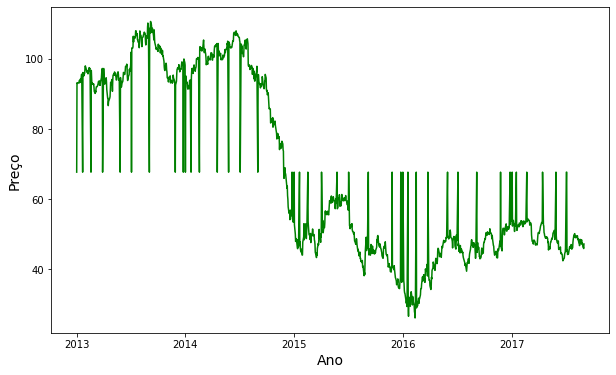

In [73]:
#Analise Temporal do Preço do Petróleo por Ano
plt.figure(figsize=(10,6))
plt.plot(petroleo.data,petroleo.dcoilwtico,color='green',linestyle='solid')
plt.xlabel('Ano',fontsize=14)
plt.ylabel('Preço',fontsize=14)
plt.show()

In [74]:
#Quantidade de Lojas que possuímos
np.unique(lojas['store_nbr'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54], dtype=int64)

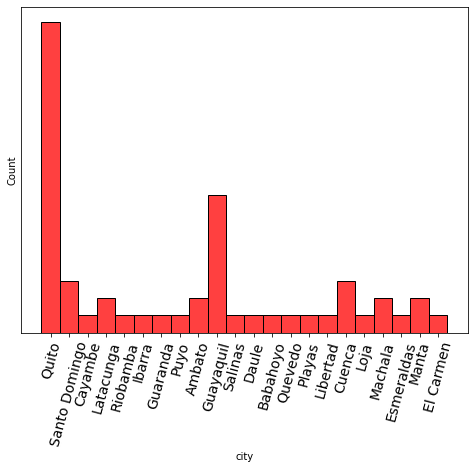

In [75]:
#Vamos ver a Distribuição das lojas de acordo com as cidades
plt.figure(figsize=(8,6))
sns.histplot(lojas['city'],color='red',bins=10)
plt.yticks([])
plt.xticks(rotation=75,fontsize=14)
plt.show()

In [76]:
#As top 50 maiores transações
transacoes_50 = transacoes.nlargest(50,'transactions')

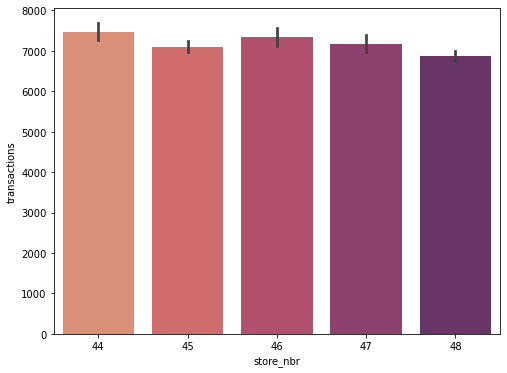

In [77]:
#O valor das maiores transações e as lojas que a fizeram
plt.figure(figsize=(8,6))
sns.barplot(data=transacoes_50,x='store_nbr',y='transactions',palette='flare')
plt.show()

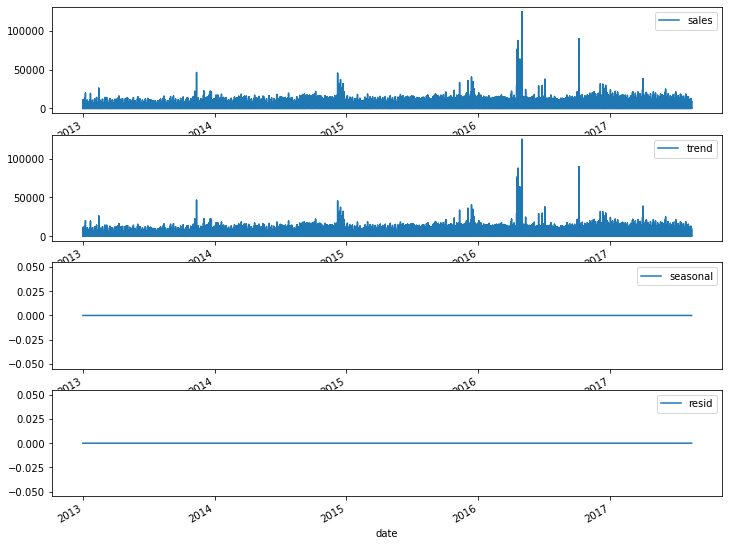

In [78]:
serie = seasonal_decompose(x=treino['sales'],model='additive',extrapolate_trend='freq',period=1)
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,10))
serie.observed.plot(ax=ax1,legend='Observed')
serie.trend.plot(ax=ax2,legend='Trend')
serie.seasonal.plot(ax=ax3,legend='Seasonal')
serie.resid.plot(ax=ax4,legend='Resid')
plt.show()

# Pré-Processamento dos Dados.

In [134]:
X = treino[['sales','id']]
y = treino['sales']

In [135]:
#Divisão dos dados de treino e teste
X_treino,X_teste,y_treino,y_teste = train_test_split(X,y,test_size=0.3)

In [136]:
#Tamanho dos Dados de Treino
print(f'X_treino = {len(X_treino)}')
print(f'y_treino = {len(y_treino)}')

X_treino = 2100621
y_treino = 2100621


# Criação e Avaliação dos Modelos.

In [137]:
modelo_xgb = XGBRegressor(n_estimators=200,max_depth=2,learning_rate=1,
                         sampling_method='gradient_based')

In [138]:
modelo_xgb.fit(X_treino,y_treino)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='', learning_rate=1,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=2,
             max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [139]:
modelo_xgb.score(X_treino,y_treino)

0.9999556770827559

In [140]:
predicoes = modelo_xgb.predict(X_teste)

In [141]:
print(f'Previsto: {predicoes[0]:.2f}\nReal: {y_teste[0]:.2f}')

Previsto: 8431.35
Real: 8422.00


In [142]:
avaliacao = mean_absolute_error(y_teste,predicoes)
avaliacao

3.1321264544669116

# Salvando as Predições.

In [143]:
with open('PREDICÕES.csv', 'w', newline='', encoding='utf-8') as out:
    escrever = csv.writer(out)
    for linhas in predicoes:
        for id in X_teste.id:
            escrever.writerow([linhas,id])


KeyboardInterrupt

